In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv


# Prepare data

In [2]:
train_data = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv',index_col=0)
test_data = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv',index_col=0)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Feature engineering

In [3]:
def add_attributes(df):
    
    def count_consecutive_out(y):
        return y * (y.groupby((y != y.shift()).cumsum()).cumcount() + 1)
    
    C_COEFF_DIV = 1000
    df['time_step_prev'] = df.groupby('breath_id')['time_step'].shift(1).fillna(0)
    df['time_delta'] = df['time_step']-df['time_step_prev']
    
    df['u_in_prev'] = df.groupby('breath_id')['u_in'].shift(1).fillna(0)
    df['u_out_prev'] = df.groupby('breath_id')['u_out'].shift(1).fillna(0)
    
    df['u_in_delta'] = ((df['u_in_prev']+df['u_in'])* df['time_delta'])/2    
    df['coeff'] = 1/df['R'] + df['C']/C_COEFF_DIV#higher R -> harder to blow, higher C -> easier to blow
    df['u_in_delta_coeff'] = df['u_in_delta']*df['coeff']
    
    #df['u_out_consec'] = df.groupby('breath_id')['u_out'].transform(count_consecutive_out)
     
    #df.drop([], axis=1, inplace=True)
    return df

In [4]:
train_data = add_attributes(train_data)
train_data.head(10)

,breath_id,R,C,time_step,u_in,u_out,pressure,time_step_prev,time_delta,u_in_prev,u_out_prev,u_in_delta,coeff,u_in_delta_coeff
id,,,,,,,,,,,,,,
1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.000000,0.0,0.000000,0.1,0.000000
2,1,20,50,0.033652,18.383041,0,5.907794,0.000000,0.033652,0.083334,0.0,0.310718,0.1,0.031072
3,1,20,50,0.067514,22.509278,0,7.876254,0.033652,0.033862,18.383041,0.0,0.692350,0.1,0.069235
4,1,20,50,0.101542,22.808822,0,11.742872,0.067514,0.034028,22.509278,0.0,0.771038,0.1,0.077104
5,1,20,50,0.135756,25.355850,0,12.234987,0.101542,0.034213,22.808822,0.0,0.823936,0.1,0.082394
6,1,20,50,0.169698,27.259866,0,12.867706,0.135756,0.033942,25.355850,0.0,0.892947,0.1,0.089295
7,1,20,50,0.203708,27.127486,0,14.695562,0.169698,0.034010,27.259866,0.0,0.924862,0.1,0.092486
8,1,20,50,0.237723,26.807732,0,15.890699,0.203708,0.034015,27.127486,0.0,0.917295,0.1,0.091730
9,1,20,50,0.271776,27.864715,0,15.539188,0.237723,0.034054,26.807732,0.0,0.930902,0.1,0.093090


In [5]:
y_train = train_data['pressure']
X_train = train_data.drop(['pressure','breath_id'],axis=1)

In [6]:
test_data = add_attributes(test_data)
X_test = test_data.drop(['breath_id'],axis=1)

In [7]:
from sklearn.preprocessing import RobustScaler
RS = RobustScaler()
X_train = RS.fit_transform(X_train)
X_test = RS.transform(X_test)

In [8]:
STEPS = 80
N_FEATURES = X_train.shape[1]

In [9]:
y_train = y_train.values.reshape(-1,STEPS)
X_train = X_train.reshape(-1,STEPS,N_FEATURES)
X_test = X_test.reshape(-1,STEPS,N_FEATURES)

# Prepare model

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import InputLayer,Dense,LSTM,Dropout,Flatten,Bidirectional

2021-10-05 13:43:58.935093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [11]:
def get_model():
    model = keras.Sequential([
        InputLayer(input_shape=X_train.shape[-2:]),
        Bidirectional(LSTM(1024, return_sequences=True)),
        Bidirectional(LSTM(512, return_sequences=True)),
        Bidirectional(LSTM(256, return_sequences=True)),
        Bidirectional(LSTM(128, return_sequences=True)),
        #Flatten(),
        Dense(128, activation="selu"),
        #Dropout(0.3),
        #Dense(150, activation="swish"),
        #Dropout(0.2),
        Dense(1)#, activation="selu")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mean_squared_error',metrics=['mse','mae'])
    return model

In [12]:
'''
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    model = get_model()
'''

'\ntpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n\nwith tpu_strategy.scope():\n    model = get_model()\n'

Train and make predictions within 5-fold cross validation

In [13]:
from sklearn.model_selection import KFold

In [14]:
'''
kf = KFold(n_splits=5, shuffle=True, random_state=2137)
test_predictions = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('Fold ',fold,' of 5')
    X_t, X_val = X_train[train_idx], X_train[test_idx]
    y_t, y_val = y_train[train_idx], y_train[test_idx]
    
    #callback_1 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model = get_model()
    history = model.fit(X_t, y_t, 
                  validation_data=(X_val, y_val), 
                  epochs=100, batch_size=512,
                  verbose=1)
    
    plt.figure(figsize=(15,5))
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epoch = range(1,len(loss)+1)
    plt.plot(epoch, loss, 'r' , label="Training")
    plt.plot(epoch, val_loss, 'b', label="Validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.show()
    test_predictions.append(model.predict(X_test).squeeze().reshape(-1, 1).squeeze())
'''

'\nkf = KFold(n_splits=5, shuffle=True, random_state=2137)\ntest_predictions = []\nfor fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):\n    print(\'Fold \',fold,\' of 5\')\n    X_t, X_val = X_train[train_idx], X_train[test_idx]\n    y_t, y_val = y_train[train_idx], y_train[test_idx]\n    \n    #callback_1 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)\n    model = get_model()\n    history = model.fit(X_t, y_t, \n                  validation_data=(X_val, y_val), \n                  epochs=100, batch_size=512,\n                  verbose=1)\n    \n    plt.figure(figsize=(15,5))\n    loss=history.history[\'loss\']\n    val_loss=history.history[\'val_loss\']\n    epoch = range(1,len(loss)+1)\n    plt.plot(epoch, loss, \'r\' , label="Training")\n    plt.plot(epoch, val_loss, \'b\', label="Validation")\n    plt.legend()\n    plt.xlabel("Epochs")\n    plt.ylabel("Loss")\n    plt.title(\'Training and validation loss\')\n    plt.

Add callback to save weights that contributed to the best achieved loss

In [15]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [16]:
model = get_model()
history = model.fit(X_train, y_train,  
              epochs=60, batch_size=512,
              verbose=1, callbacks=[model_checkpoint_callback])

2021-10-05 13:44:02.716190: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 13:44:02.719203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-05 13:44:02.762724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-05 13:44:02.763363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-05 13:44:02.763424: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-05 13:44:02.789250: I tensorflow/stream_executor/platform/def

Epoch 1/60


2021-10-05 13:44:18.318726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-05 13:44:19.094053: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-05 13:44:19.148719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


148/148 [==============================] - 144s 870ms/step - loss: 27.6138 - mse: 27.6138 - mae: 2.9292
Epoch 2/60
148/148 [==============================] - 129s 873ms/step - loss: 1.9626 - mse: 1.9626 - mae: 0.8513
Epoch 3/60
148/148 [==============================] - 129s 872ms/step - loss: 1.0665 - mse: 1.0665 - mae: 0.6458
Epoch 4/60
148/148 [==============================] - 129s 873ms/step - loss: 0.8464 - mse: 0.8464 - mae: 0.5824
Epoch 5/60
148/148 [==============================] - 129s 872ms/step - loss: 0.6952 - mse: 0.6952 - mae: 0.5296
Epoch 6/60
148/148 [==============================] - 129s 872ms/step - loss: 0.6703 - mse: 0.6703 - mae: 0.5162
Epoch 7/60
148/148 [==============================] - 129s 873ms/step - loss: 0.5945 - mse: 0.5945 - mae: 0.4884
Epoch 8/60
148/148 [==============================] - 129s 872ms/step - loss: 0.5987 - mse: 0.5987 - mae: 0.4910
Epoch 9/60
148/148 [==============================] - 129s 872ms/step - loss: 0.5182 - mse: 0.5182 - mae:

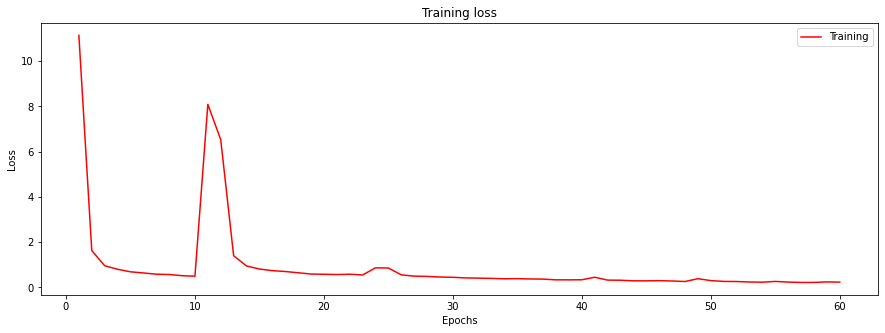

In [17]:
plt.figure(figsize=(15,5))
loss=history.history['loss']
#val_loss=history.history['val_loss']
epoch = range(1,len(loss)+1)
plt.plot(epoch, loss, 'r' , label="Training")
#plt.plot(epoch, val_loss, 'b', label="Validation")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training loss')
plt.show()

# Final predictions of test pressures

In [18]:
model.load_weights(checkpoint_filepath)
y_pred_test = model.predict(X_test).squeeze().reshape(-1, 1).squeeze()#sum(test_predictions)/5

In [19]:
output = pd.DataFrame({'id': test_data.index, 'pressure': y_pred_test})
output.to_csv('submission.csv', index=False)